Let's load our datasets, in case there are not available locally, download them.

In [ ]:
import os
import sys

from src.data_loaders.load_raw import load_raw_data_as_df, delete_data


In [ ]:
# example load of a dataset
data, dataset_config = load_raw_data_as_df("carte_jp_anime")

# to delete the dataset
delete_data("carte_jp_anime", dataset_config)

now let's get a list of all CARTE datasets

In [6]:
from utils.handle_files import read_yaml
from configs.directory import config_directory

config_path = config_directory['dataset_config']
data_config_yaml = read_yaml(config_path)
carte_datasets_list = data_config_yaml['carte_datasets']
print(f"First few dataset names: {carte_datasets_list[0:5]}")

First few dataset names: ['carte_anime_planet', 'carte_babies_r_us', 'carte_beer_ratings', 'carte_bikedekho', 'carte_bikewale']


To begin our analysis, we will look into what happens with the original feature space of each dataset by running the CARTE preprocessing

In [ ]:
import json
import os
from carte_pp import preprocess_data as preprocess_data_carte
import pandas as pd
import numpy as np

output_file = "extracted_features.json"

# Load existing data if the file exists
if os.path.exists(output_file):
    with open(output_file, "r") as f:
        try:
            stored_data = json.load(f)
        except json.JSONDecodeError:
            stored_data = {}
else:
    stored_data = {}

for dataset_name in carte_datasets_list:
    df_dict, data_config = load_raw_data_as_df(dataset_name)
    file_path = data_config['files'][0]
    file_name = file_path.split('/')[-1]
    
    data_df = df_dict[file_name]
    dataset_name_ = dataset_name.replace('carte_', '')
    
    data_name, data, target_name, entity_name, task, repeated = preprocess_data_carte(data_df, dataset_name_)
    
    example_features = {}
    for feature in data.columns:
        example_value = None
        for val in data[feature]:
            if pd.notnull(val):
                example_value = val
                break
        if example_value is not None:
            if isinstance(example_value, (np.integer, np.floating)):
                example_value = example_value.item()
            elif isinstance(example_value, np.ndarray):
                example_value = example_value.tolist()
        example_features[feature] = example_value
    
    stored_data[dataset_name] = example_features  # Overwrite existing dataset entry
    
    # Save progress after processing each dataset
    with open(output_file, "w") as f:
        json.dump(stored_data, f, indent=4)
    
    print(f"Processed and saved: {dataset_name}")


In [ ]:
# to delete the datasets after extracting the features features
if True:
    for dataset in carte_datasets_list:
        delete_data(dataset)

### Set up OpenAI api

In [ ]:
openai_key = "YOUR_OPENAI_API_KEY"  # Replace with your actual OpenAI API key
from openai import OpenAI
client = OpenAI(api_key=openai_key)

### The follwing code will extract categories of data given their names (could be potentially improved to be based on rough features space structure too)
-> we are doing this just to save compute and not evaluate all pairs!

In [ ]:
import re
import json

def extract_json(response_content):
    """
    Remove markdown code block formatting (```json ... ```) from the response content,
    then parse and return the JSON object.
    """
    cleaned = re.sub(r"^```(json)?\s*", "", response_content)
    cleaned = re.sub(r"\s*```$", "", cleaned)
    return json.loads(cleaned)

# Define the prompt template
prompt = """
You are provided with a list of dataset names that imply clear similarity in feature space.
Your task is to analyze the dataset names and group them into categories based on their
inherent similarity. Use semantic reasoning to determine which datasets belong together.
The groups should reflect the underlying feature space and the nature of the data.
For example datasets with tree atributes and flower attributes should be in the same category,
even though they are easily distinguishable.

Return your output strictly in JSON format, with no additional text.
The JSON object should have keys as category names (your chosen names that reflect the grouped datasets) and values
as arrays of dataset names that belong to that category.

For example, if some dataset names suggest they are related to wines,
you might group them under a category "Wines"; if some suggest they are related to vehicles,
group them under "Vehicles", and so on.

Input:
{dataset_names}

Return your output in the following JSON structure:
{{
   "Category1": ["dataset_name1", "dataset_name2", ...],
   "Category2": ["dataset_name3", "dataset_name4", ...],
   ...
}}
Do not provide any additional text in the output. Only the JSON object with the categories and dataset names.
"""

# Define the output file path
output_path = "json_files/feature_space_categories.json"

# Format the prompt with the dataset names (joined into a string)
prompt_text = prompt.format(dataset_names=", ".join(carte_datasets_list))

# Call the LLM API
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt_text}
    ],
    seed=42
).choices[0].message.content

# If the response is a string, parse it, otherwise assume it's already a dict
if isinstance(response, str):
    try:
        result = extract_json(response)
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        result = response
else:
    result = response

# Save the response (which is in JSON format) to the output file
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result, f, indent=4)

print(f"Feature space categories saved to {output_path}")


### The follwing code will run over all pairs within a single category and evaluate the similarity of their features

In [ ]:
import itertools
import json
import re
import sys

def extract_json(response_content):
    """
    Remove markdown code block formatting (```json ... ```) from the response content,
    then parse and return the JSON object.
    """
    cleaned = re.sub(r"^```(json)?\s*", "", response_content)
    cleaned = re.sub(r"\s*```$", "", cleaned)
    return json.loads(cleaned)

def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=50):
    """
    Print a progress bar in the console.
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(bar_length * iteration // total)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    if iteration == total:
        print()

# Load the dataset descriptions
datasets_file_path = "json_files/extracted_features.json"
with open(datasets_file_path, "r", encoding="utf-8") as f:
    datasets = json.load(f)

# Load the feature space categories file
categories_file_path = "json_files/feature_space_categories.json"
with open(categories_file_path, "r", encoding="utf-8") as f:
    categories = json.load(f)

# Define the prompt format template
format_template_obj = {
    "similar_features": [
        {
            "dataset1_col_name": {"<col_name>": "<example_value>"},
            "dataset2_col_name": {"<col_name>": "<example_value>"},
            "reason": "<Brief reason based on data type, structure, or naming similarity>"
        }
    ],
    "dissimilar_features": {
        "dataset1": [
            {
                "col_name": "<col_name>",
                "reason": "<Why this feature has no equivalent in dataset2>"
            }
        ],
        "dataset2": [
            {
                "col_name": "<col_name>",
                "reason": "<Why this feature has no equivalent in dataset1>"
            }
        ]
    },
}

# Define the prompt template for feature space comparison
prompt_template = """
Analyze and compare the feature space of two datasets: {dataset1_name} and {dataset2_name}.
Identify relationships between feature names using semantic reasoning.

**Your Task:**
1. **Find Similar Features**: Identify columns that represent the same concept, even if their names differ.
   - Match based on **data type, structure, and naming conventions**, rather than relying solely on example values.
   - Consider cases where **one feature in a dataset maps to multiple features** in the other dataset.
   - Note: When a column represents an inherent property of the entity (such as its name, title, or composition/build/materials), treat it as similar across datasets unless context clearly indicates a different meaning.

2. **Identify Dissimilar Features**: Columns that do not have a meaningful equivalent in the other dataset.
   - Consider **data type mismatches** (e.g., numeric vs. categorical).
   - Features that belong to completely different contexts should be classified as dissimilar.
   - For instance, even if the same term (e.g., "location") is used in both datasets, they should only be considered similar if their contexts align.

### Additional Guidelines:
- **Return column names, with original example values.** Do not assume or generate example values.
- Consider **semantic similarity** beyond direct string matching.
- Account for **differences in feature naming conventions** (e.g., "price" vs. "cost", "region" vs. "province").
- **Preserve structured output strictly in JSON format**—avoid any additional text or explanations.
- Make sure you always return a pair of features for the "similar_features" section.

### Expected Output:
{format_template}

### Dataset 1: {dataset1_name}
{dataset1_values}

### Dataset 2: {dataset2_name}
{dataset2_values}
"""

# Define the output file path for category-based comparisons
output_path = "json_files/category_feature_space_comparisons.json"

results = {}

# Count total pairs across all categories for the progress bar
total_pairs = 0
for category, dataset_names in categories.items():
    if len(dataset_names) >= 2:
        total_pairs += len(list(itertools.combinations(dataset_names, 2)))

current_pair = 0

# Loop over each category with at least 2 datasets
sum_pairs = 0

for category, dataset_names in categories.items():

    if len(dataset_names) < 2:
        continue  # Skip categories with fewer than 2 members
    sum_pairs += len(list(itertools.combinations(dataset_names, 2)))

    results[category] = {}
    # Create all unique pairs within the category
    pairs = list(itertools.combinations(dataset_names, 2))
    for dataset1_name, dataset2_name in pairs:
        # Ensure the datasets exist in the features file
        if dataset1_name not in datasets or dataset2_name not in datasets:
            continue

        dataset1 = datasets[dataset1_name]
        dataset2 = datasets[dataset2_name]

        prompt_text = prompt_template.format(
            dataset1_name=dataset1_name,
            dataset2_name=dataset2_name,
            format_template=json.dumps(format_template_obj, indent=4),
            dataset1_values=json.dumps(dataset1, indent=4),
            dataset2_values=json.dumps(dataset2, indent=4)
        )

        if True:
            # Call LLM API for the current pair (adjust as needed)
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt_text}
                ],
                seed=42
            ).choices[0].message.content

            pair_key = f"{dataset1_name} vs {dataset2_name}"
            try:
                results[category][pair_key] = extract_json(response)
            except json.JSONDecodeError as e:
                print(f"\nError parsing JSON for {pair_key}: {e}")
                results[category][pair_key] = response  # Fallback to raw response

            current_pair += 1
            print_progress(current_pair, total_pairs, prefix="Progress", suffix="Complete", bar_length=50)

            # Dump intermediate results after each pair
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(results, f, indent=4)

        else: print(f"Skipping API call for {dataset1_name} vs {dataset2_name}")

    print(f"\nCompleted category: {category} ({len(pairs)} pairs)")
print(f"\nCompleted all categories ({sum_pairs} pairs)")

print(f"\nCategory-based feature space comparison results saved to {output_path}")


sim(A→B)=∣F_A ∩ F_B​∣ / ​|F_A|

/tmp/ipykernel_790283/3577791481.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix_binary = matrix.applymap(lambda x: 1 if x >= 0.5 else 0)
/tmp/ipykernel_790283/3577791481.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cont = cm.get_cmap("viridis").copy()


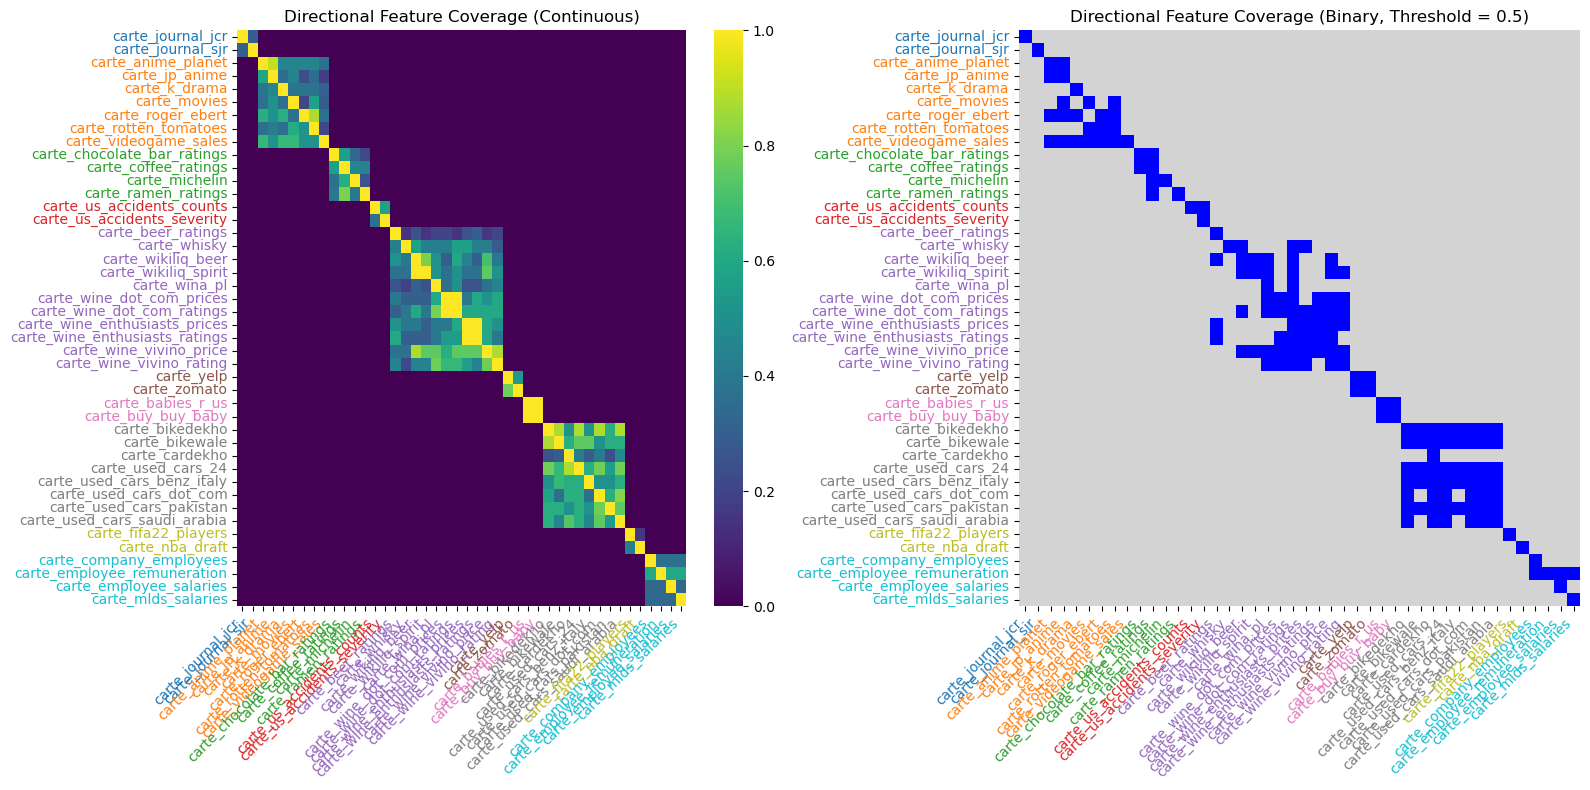

In [ ]:
import numpy as np
from matplotlib import cm
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the similarity metrics JSON file.
with open('json_files/category_feature_space_comparisons.json', 'r') as f:
    metrics = json.load(f)

# Dictionary to hold directional similarity values and group mapping.
# Directional similarity from ds1 to ds2 = (# similar features) / (total features in ds1)
directional_similarity = {}
group_mapping = {}  # maps dataset name to its group (background)
dataset_names = set()

# Preserve group order from the JSON (Python 3.7+ maintains insertion order).
group_order = list(metrics.keys())

# Process each group and each comparison.
for group, comparisons in metrics.items():
    for comp, details in comparisons.items():
        similar_features = details.get("similar_features", [])
        num_similar = len(similar_features)
        # Total features for dataset1 = similar features + dissimilar features in dataset1.
        dissim_ds1 = details.get("dissimilar_features", {}).get("dataset1", [])
        total_ds1 = num_similar + len(dissim_ds1)
        # Total features for dataset2 = similar features + dissimilar features in dataset2.
        dissim_ds2 = details.get("dissimilar_features", {}).get("dataset2", [])
        total_ds2 = num_similar + len(dissim_ds2)
        
        # Compute directional similarities.
        sim_ds1_to_ds2 = num_similar / total_ds1 if total_ds1 != 0 else 0
        sim_ds2_to_ds1 = num_similar / total_ds2 if total_ds2 != 0 else 0
        
        # Expecting comparison key in the format "ds1 vs ds2"
        ds1, ds2 = [s.strip() for s in comp.split("vs")]
        directional_similarity[(ds1, ds2)] = sim_ds1_to_ds2
        directional_similarity[(ds2, ds1)] = sim_ds2_to_ds1
        
        dataset_names.update([ds1, ds2])
        
        # Record the group (background) for each dataset.
        if ds1 not in group_mapping:
            group_mapping[ds1] = group
        if ds2 not in group_mapping:
            group_mapping[ds2] = group

# Order datasets based on their group (using the order from the JSON) and then by name.
ordered_datasets = sorted(dataset_names, key=lambda ds: (group_order.index(group_mapping.get(ds, group_order[-1])), ds))

# Build a DataFrame for the directional similarity matrix.
matrix = pd.DataFrame(index=ordered_datasets, columns=ordered_datasets, dtype=float)

# Fill the diagonal with 1 (each dataset fully covers itself).
for ds in ordered_datasets:
    matrix.loc[ds, ds] = 1.0

# Fill the matrix with the directional similarity values.
for (ds1, ds2), sim in directional_similarity.items():
    matrix.loc[ds1, ds2] = sim

# Replace missing values with 0 (i.e. no recorded connection).
matrix = matrix.fillna(0)

# Create a masked array for the continuous heatmap: mask 0 values (to show as light grey).
matrix_masked = np.ma.masked_equal(matrix.values, 0)

# Create a binary matrix using a threshold of 0.5.
matrix_binary = matrix.applymap(lambda x: 1 if x >= 0.5 else 0)

# Get a copy of the viridis colormap and set masked cells to light grey for the continuous heatmap.
cmap_cont = cm.get_cmap("viridis").copy()
cmap_cont.set_bad(color="lightgrey")

# Create a binary colormap: 0 -> lightgrey, 1 -> blue.
cmap_binary = ListedColormap(["lightgrey", "blue"])

# Prepare a palette for row/column labels based on group membership.
group_palette = sns.color_palette("tab10", n_colors=len(group_order))
group_color_mapping = {group: group_palette[i] for i, group in enumerate(group_order)}
def get_label_color(ds):
    return group_color_mapping.get(group_mapping.get(ds, None), "grey")

# Plot the continuous and binary heatmaps side by side.
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Continuous directional similarity heatmap.
sns.heatmap(matrix_masked, cmap=cmap_cont, cbar=True, annot=False,
            xticklabels=ordered_datasets, yticklabels=ordered_datasets, ax=axs[0])
axs[0].set_title("Directional Feature Coverage (Continuous)")

# Binary directional similarity heatmap.
sns.heatmap(matrix_binary, cmap=cmap_binary, cbar=False, annot=False,
            xticklabels=ordered_datasets, yticklabels=ordered_datasets, ax=axs[1])
axs[1].set_title("Directional Feature Coverage (Binary, Threshold = 0.5)")

# Customize tick label colors for both subplots.
for ax in axs:
    for tick_label in ax.get_xticklabels():
        ds = tick_label.get_text()
        tick_label.set_color(get_label_color(ds))
        tick_label.set_rotation(45)
        tick_label.set_horizontalalignment('right')
    for tick_label in ax.get_yticklabels():
        ds = tick_label.get_text()
        tick_label.set_color(get_label_color(ds))

plt.tight_layout()
plt.show()


In [ ]:
import itertools
import json
import re
import sys

def extract_json(response_content):
    """
    Remove markdown code block formatting (```json ... ```) from the response content,
    then parse and return the JSON object.
    """
    cleaned = re.sub(r"^```(json)?\s*", "", response_content)
    cleaned = re.sub(r"\s*```$", "", cleaned)
    return json.loads(cleaned)

def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=50):
    """
    Print a progress bar in the console.
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(bar_length * iteration // total)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    if iteration == total:
        print()

# Load the dataset descriptions
datasets_file_path = "json_files/extracted_features.json"
with open(datasets_file_path, "r", encoding="utf-8") as f:
    datasets = json.load(f)

# Define the list of unsimilar datasets
unsimilar_datasets = [
    "carte_bikedekho", "carte_cardekho", "carte_used_cars_24",
    "carte_museums", "carte_spotify", "carte_prescription_drugs",
    "carte_wine_vivino_rating", "carte_videogame_sales", "carte_anime_planet"
]

# Define the prompt format template
format_template_obj = {
    "similar_features": [
        {
            "dataset1_col_name": {"<col_name>": "<example_value>"},
            "dataset2_col_name": {"<col_name>": "<example_value>"},
            "reason": "<Brief reason based on data type, structure, or naming similarity>"
        }
    ],
    "dissimilar_features": {
        "dataset1": [
            {
                "col_name": "<col_name>",
                "reason": "<Why this feature has no equivalent in dataset2>"
            }
        ],
        "dataset2": [
            {
                "col_name": "<col_name>",
                "reason": "<Why this feature has no equivalent in dataset1>"
            }
        ]
    },
}

# Define the prompt template for feature space comparison
prompt_template = """
Analyze and compare the feature space of two datasets: {dataset1_name} and {dataset2_name}.
Identify relationships between feature names using semantic reasoning.

**Your Task:**
1. **Find Similar Features**: Identify columns that represent the same concept, even if their names differ.
   - Match based on **data type, structure, and naming conventions**, rather than relying solely on example values.
   - Consider cases where **one feature in a dataset maps to multiple features** in the other dataset.
   - Note: When a column represents an inherent property of the entity (such as its name, title, or composition/build/materials), treat it as similar across datasets unless context clearly indicates a different meaning.

2. **Identify Dissimilar Features**: Columns that do not have a meaningful equivalent in the other dataset.
   - Consider **data type mismatches** (e.g., numeric vs. categorical).
   - Features that belong to completely different contexts should be classified as dissimilar.
   - For instance, even if the same term (e.g., "location") is used in both datasets, they should only be considered similar if their contexts align.

### Additional Guidelines:
- **Return column names, with original example values.** Do not assume or generate example values.
- Consider **semantic similarity** beyond direct string matching.
- Account for **differences in feature naming conventions** (e.g., "price" vs. "cost", "region" vs. "province").
- **Preserve structured output strictly in JSON format**—avoid any additional text or explanations.
- Make sure you always return a pair of features for the "similar_features" section.

### Expected Output:
{format_template}

### Dataset 1: {dataset1_name}
{dataset1_values}

### Dataset 2: {dataset2_name}
{dataset2_values}
"""

# Define the output file path for unsimilar dataset comparisons
output_path = "json_files/unsimilar_and_cars_datasets_comparisons.json"

results = {}

# Create all unique pairs within unsimilar_datasets
pairs = list(itertools.combinations(unsimilar_datasets, 2))
total_pairs = len(pairs)
current_pair = 0

for dataset1_name, dataset2_name in pairs:
    # Ensure the datasets exist in the features file
    if dataset1_name not in datasets or dataset2_name not in datasets:
        continue

    dataset1 = datasets[dataset1_name]
    dataset2 = datasets[dataset2_name]

    prompt_text = prompt_template.format(
        dataset1_name=dataset1_name,
        dataset2_name=dataset2_name,
        format_template=json.dumps(format_template_obj, indent=4),
        dataset1_values=json.dumps(dataset1, indent=4),
        dataset2_values=json.dumps(dataset2, indent=4)
    )

    # Call LLM API for the current pair (adjust the API call as needed)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt_text}
        ],
        seed=42
    ).choices[0].message.content

    pair_key = f"{dataset1_name} vs {dataset2_name}"
    try:
        results[pair_key] = extract_json(response)
    except json.JSONDecodeError as e:
        print(f"\nError parsing JSON for {pair_key}: {e}")
        results[pair_key] = response  # Fallback to raw response

    current_pair += 1
    print_progress(current_pair, total_pairs, prefix="Progress", suffix="Complete", bar_length=50)

    # Dump intermediate results after each pair
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=4)

print(f"\nUnsimalr dataset feature space comparison results saved to {output_path}")


Invalid format for key: carte_cardekho vs carte_museums


/tmp/ipykernel_46912/1579964791.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cont = cm.get_cmap("viridis").copy()
/tmp/ipykernel_46912/1579964791.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix_binary = matrix.applymap(lambda x: 1 if x >= 0.5 else 0)


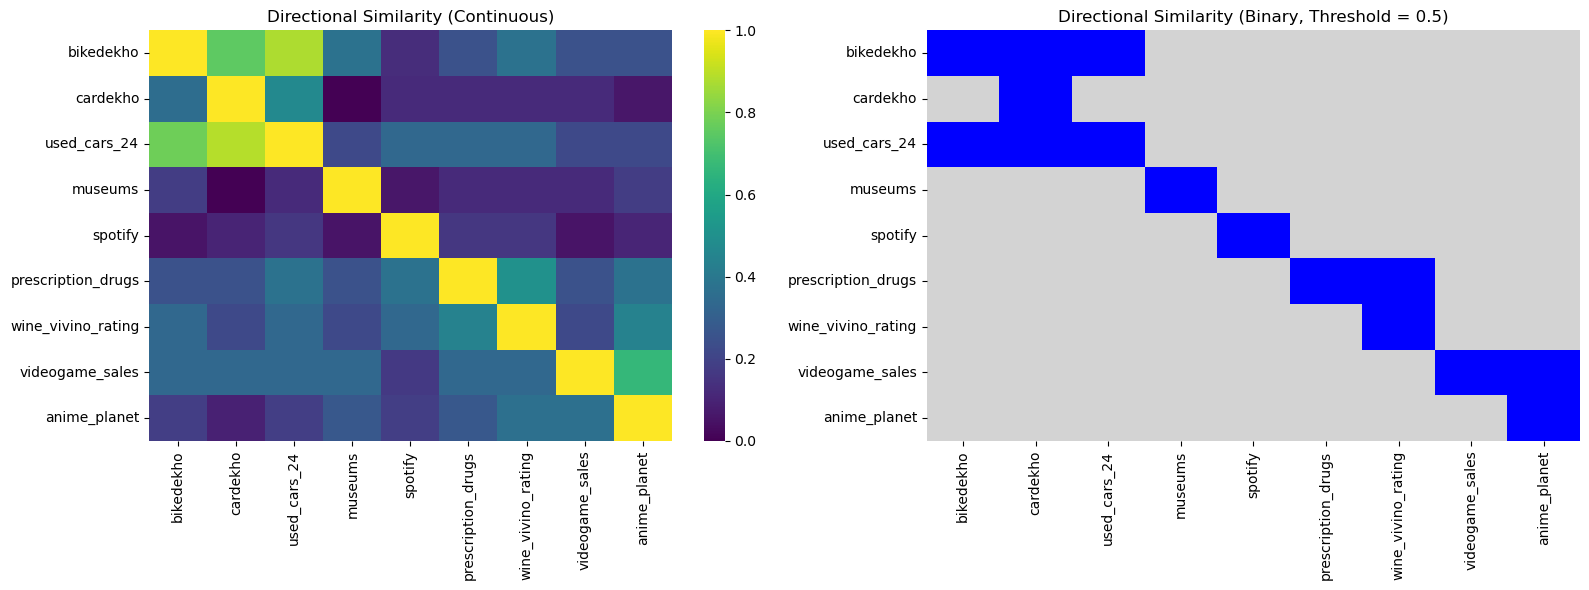

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Define the unsimilar datasets list (order as desired)
unsimilar_datasets = [
    "carte_bikedekho", "carte_cardekho", "carte_used_cars_24",
    "carte_museums", "carte_spotify", "carte_prescription_drugs",
    "carte_wine_vivino_rating", "carte_videogame_sales", "carte_anime_planet"
]

# Generate labels without the "carte_" prefix.
dataset_labels = [ds.replace("carte_", "") for ds in unsimilar_datasets]

# Load the API comparison results for unsimilar datasets.
results_file_path = "json_files/unsimilar_and_cars_datasets_comparisons.json"
with open(results_file_path, "r", encoding="utf-8") as f:
    results = json.load(f)

# Create a DataFrame for directional similarity.
# Rows: base dataset (features being covered)
# Columns: compared dataset.
matrix = pd.DataFrame(index=unsimilar_datasets, columns=unsimilar_datasets, dtype=float)

# Set self-similarity to 1.
for ds in unsimilar_datasets:
    matrix.loc[ds, ds] = 1.0

# Fill in directional similarities from the results.
# For each pair, compute:
#   sim(ds1 -> ds2) = (# similar features) / ( # similar features + # dissimilar features in ds1)
#   sim(ds2 -> ds1) = (# similar features) / ( # similar features + # dissimilar features in ds2)
for key, res in results.items():
    try:
        ds1, ds2 = [s.strip() for s in key.split("vs")]
    except Exception as e:
        print(f"Error parsing key: {key}: {e}")
        continue

    if isinstance(res, dict) and "similar_features" in res and "dissimilar_features" in res:
        similar_features = res["similar_features"]
        num_similar = len(similar_features)
        dissim_ds1 = res["dissimilar_features"].get("dataset1", [])
        dissim_ds2 = res["dissimilar_features"].get("dataset2", [])
        total_ds1 = num_similar + len(dissim_ds1)
        total_ds2 = num_similar + len(dissim_ds2)
        sim_ds1_to_ds2 = num_similar / total_ds1 if total_ds1 else 0
        sim_ds2_to_ds1 = num_similar / total_ds2 if total_ds2 else 0

        if ds1 in unsimilar_datasets and ds2 in unsimilar_datasets:
            matrix.loc[ds1, ds2] = sim_ds1_to_ds2
            matrix.loc[ds2, ds1] = sim_ds2_to_ds1
    else:
        print(f"Invalid format for key: {key}")

matrix = matrix.fillna(0)

# Create continuous heatmap data.
# Mask 0 values so they appear as light grey.
matrix_masked = np.ma.masked_equal(matrix.values, 0)
cmap_cont = cm.get_cmap("viridis").copy()
cmap_cont.set_bad(color="lightgrey")

# Create binary matrix using a threshold of 0.5.
matrix_binary = matrix.applymap(lambda x: 1 if x >= 0.5 else 0)
cmap_binary = ListedColormap(["lightgrey", "blue"])

# Plot both heatmaps side by side.
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Continuous heatmap
sns.heatmap(matrix_masked, cmap=cmap_cont, cbar=True, annot=False,
            xticklabels=dataset_labels, yticklabels=dataset_labels, ax=axs[0])
axs[0].set_title("Directional Similarity (Continuous)")

# Binary heatmap
sns.heatmap(matrix_binary, cmap=cmap_binary, cbar=False, annot=False,
            xticklabels=dataset_labels, yticklabels=dataset_labels, ax=axs[1])
axs[1].set_title("Directional Similarity (Binary, Threshold = 0.5)")

plt.tight_layout()
plt.show()
